#YÜZ GÖRÜNTÜLERİNDEN DERİN ÖĞRENME İLE DUYGU TANIMA UYGULAMASI

In [1]:
#Google Colab Kimlik Doğrulama İşlemi

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [2]:
import os

os.chdir('/gdrive/My Drive/calisma_ortami')

In [3]:
!ls

 app.py
 colabCalismaOrtami.ipynb
 Duygu_Tanima.ipynb
 EvrisimliSinirAgi.ipynb
 fer2013.csv
'IMAGENET - ResNet50 - NESNE TANIMA.ipynb'
'IMAGENET - VGG16 - NESNE TANIMA.ipynb'
'Katmanlar ve Modeller.ipynb'
 MNIST_YSA.ipynb
 nesne_tanima
'RakamTanima_CNN.ipynb adlı not defterinin kopyası'
 RNN_IMDB_UYGULAMASİ.ipynb
 save_models
 transfer_learning.ipynb
 Uygulama_Rakam_Tanima.ipynb
'Vektörler   Matrisler   Tensörler.ipynb'


In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

import keras
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Conv2D, Activation, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint

In [61]:
#Veri setinin okunması...
#Bize verilen veriseti 35887 satır ve 3 sütundan oluşuyor

root = '/gdrive/My Drive/calisma_ortami/'

data = pd.read_csv(root +'fer2013.csv')
data.shape

(35887, 3)

In [62]:
#Veriden bir kısım görelim!

data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [63]:
#Eğitim ve test performansının ölçüldüğü veri sayılarını inceleyelim.

data["Usage"].value_counts()


#Usage kolonunda verisetindeki örnekler kaç gruba ayrıldığını görebiliriz.
# Kaggleda genelde bu şekilde submit sonrası asıl test edilmesi için verisetinden bir kısmını "PrivateTest" olarak ayırırlar

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

EĞİTİM VERİSİ İÇİN ÖN İŞLEME ADIMLARI

In [64]:
np.unique(data["Usage"].values.ravel())

print('Eğitim setindeki örnek sayısı: %d'%(len(data[data.Usage == "Training"])))

Eğitim setindeki örnek sayısı: 28709


In [65]:
#Eğitim işlemi için veri kümesinde ayrılmış olan Training kısmını alıyoruz.

train_data = data [data.Usage == "Training"]#sadece eğitim örneklerini train_data değişkenine aldık

In [66]:
#eğitim örneklerinin piksel değerleri bize tablo halinde yan yana verildiği için boşluklardan parse ederek liste olarak değişkene aldık
train_pixels = train_data.pixels.str.split(" ").tolist() 

train_pixels = pd.DataFrame(train_pixels, dtype=int)
train_images = train_pixels.values
train_images = train_images.astype(np.float)

print(train_images)

print(train_images.shape)

[[ 70.  80.  82. ... 106. 109.  82.]
 [151. 150. 147. ... 193. 183. 184.]
 [231. 212. 156. ...  88. 110. 152.]
 ...
 [ 74.  81.  87. ... 188. 187. 187.]
 [222. 227. 203. ... 136. 136. 134.]
 [195. 199. 205. ...   6.  15.  38.]]
(28709, 2304)


In [67]:
#Görüntüyü 48x48 piksel şeklinde göstermek için bir fonksiyon tanımlayalım
def show(img):
    show_image = img.reshape(48,48)
    
    plt.axis('off')
    plt.imshow(show_image, cmap='gray')

Eğitim kümesinden bir örnek görsel

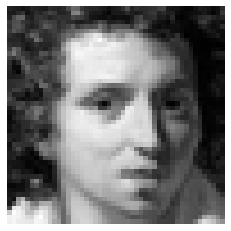

In [68]:
#Veri kümesinden 
show(train_images[1000])

In [69]:
#Eğitim kümesinde kaç sınıf bulunuyor bunu görelim.
train_labels_flat = train_data["emotion"].values.ravel()
train_labels_count = np.unique(train_labels_flat).shape[0]
print('Farklı yüz ifadelerinin sayısı: %d'%train_labels_count)

Farklı yüz ifadelerinin sayısı: 7


In [70]:
#One Hot ile eğitim kümesindeki verilerin her birine düşen sınıfı yani eğitim işlemi boyutunu görelim
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

In [71]:
y_train = dense_to_one_hot(train_labels_flat, train_labels_count)

y_train = y_train.astype(np.uint8)

print(y_train.shape)


(28709, 7)


TEST VERİSİ ÖN İŞLEME ADIMLARI

In [72]:
np.unique(data["Usage"].values.ravel()) 

print('Test verisetindeki örnek sayısı: %d'%(len(data[data.Usage == "PublicTest"])))

Test verisetindeki örnek sayısı: 3589


Eğitim işlemi için veri kümesinde ayrılmış olan PublicTest kısmını alıyoruz.

In [73]:
test_data = data[data.Usage == "PublicTest"] 
test_pixels = test_data.pixels.str.split(" ").tolist() 

test_pixels = pd.DataFrame(test_pixels, dtype=int)
test_images = test_pixels.values
test_images = test_images.astype(np.float)

print(test_images.shape)

#test örneklerinin piksel değerleri bize tablo halinde yan yana verildiği için boşluklardan parse ederek liste olarak değişkene aldık

(3589, 2304)



Eğitim kümesinden bir örnek görsel

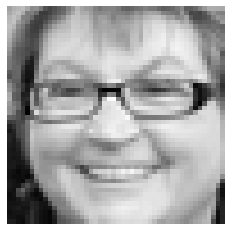

In [74]:
#bir test örneği gösterelim
show(test_images[100])

One Hot ile test kümesindeki verilerin her birine düşen sınıfı yani eğitim işlemi boyutunu görelim

In [75]:
test_labels_flat = test_data["emotion"].values.ravel()
test_labels_count = np.unique(test_labels_flat).shape[0]

y_test = dense_to_one_hot(test_labels_flat, test_labels_count)

y_test = y_test.astype(np.uint8)

print(y_test.shape)

(3589, 7)


TEST KÜMESİNDEN ÖRNEK GÖRÜNTÜLER

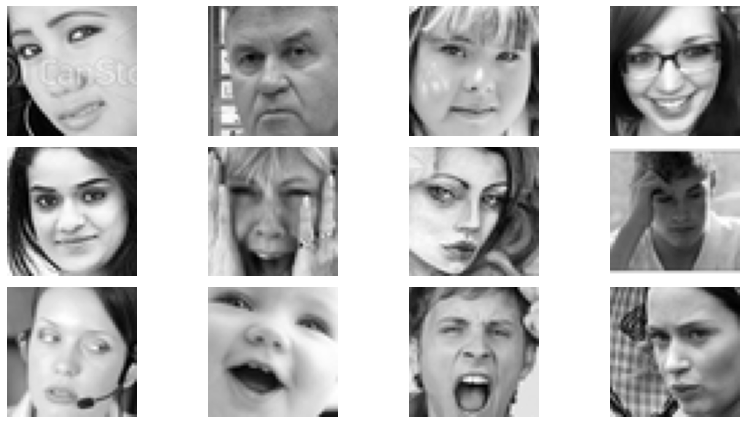

In [76]:
#test verisetinden örneklerden bir kaçını toplu halde görelim
plt.figure(0, figsize=(12,6))
for i in range(1,13):
  plt.subplot(3, 4, i)
  plt.axis('off')

  image = test_images[i].reshape(48,48)
  plt.imshow(image, cmap='gray')

plt.tight_layout()
plt.show()

DERİN EVRİŞİMLİ SİNİR AĞI MODELİ TANIMLANMASI

In [77]:
model = Sequential()

#1. KATMAN
model.add(Conv2D(128, 3, data_format="channels_last", kernel_initializer="he_normal", input_shape=(48,48,1))) #channel_last:yükseklik,genişlik,kanal sayısı şeklinde data alınacak.
model.add(BatchNormalization())
model.add(Activation('relu'))

#2. KATMAN

model.add(Conv2D(128, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.5)) #%50 unutma işlemi(nöron silme-dropout)

### 3. KATMAN
model.add(Conv2D(64, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))


### 4. KATMAN
model.add(Conv2D(64, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))

### 5. KATMAN
model.add(Conv2D(64, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.50)) #%50 unutma işlemi(nöron silme-dropout)

### 6. KATMAN
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.25)) #%25 unutma işlemi(nöron silme-dropout)


### TAM BAĞLANTI KATMANI
model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.6))#%60 unutma işlemi(nöron silme-dropout)

### Çıkış katmanı

model.add(Dense(7))
model.add(Activation('softmax')) #Sınıflama işlemi (7 duygu sınıfı var)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #opmizasyon ve başarım hesaplama metriklerinin belirlenmesi
#model özetini görselleştirelim

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 46, 46, 128)       1280      
_________________________________________________________________
batch_normalization_7 (Batch (None, 46, 46, 128)       512       
_________________________________________________________________
activation_8 (Activation)    (None, 46, 46, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 44, 44, 128)       147584    
_________________________________________________________________
batch_normalization_8 (Batch (None, 44, 44, 128)       512       
_________________________________________________________________
activation_9 (Activation)    (None, 44, 44, 128)       0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 22, 22, 128)      

Eğtim ve Test kümelerinin eleman sayısı, yükseklik ve genişlik, kanalsayısı bilgilerini ekrana yazdıralım.



In [78]:
x_train = train_images.reshape(-1, 48, 48, 1)
x_test = test_images.reshape(-1, 48, 48, 1)

print('Train:', x_train.shape)
print('Test:', x_test.shape)

Train: (28709, 48, 48, 1)
Test: (3589, 48, 48, 1)


In [79]:
#Eğitim ve Test kümelerinin eleman ve duygu sınıf sayısı.

print('Train:', y_train.shape)
print('Test:', y_test.shape)

Train: (28709, 7)
Test: (3589, 7)


Eğitim işleminin gerçekleşmesini istediğimiz epoch, batchsize gibi değerlerin belirlenmesi ve eğitim sonucunda ağırlıkların .h5 dosyası olarak kaydedilmesi işlemleri

In [ ]:
# en başarılı ağırlıkları kaydet
checkpointer = ModelCheckpoint(filepath=root + 'save_models/face_model.h5', verbose=1, save_best_only=True)

epochs = 20
batchSize = 128

# modeli çalıştır

hist = model.fit(x_train, y_train,
                 epochs=epochs,
                 shuffle=True,
                 batch_size=batchSize,
                 validation_data=(x_test, y_test),
                 callbacks=[checkpointer], verbose=2)
                
# save model to json
model_json = model.to_json()
with open(root + 'save_models/face_model.json', 'w') as json_file:
  json_file.write(model_json)

Eğitim sonucu elde edilen Eğitim ve Geçerleme (Validation) sonuçlarının grafiksel olarak ifade edilip ekrarna yazdırılması işlemleri.

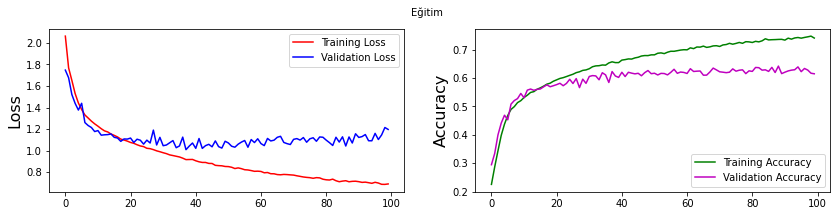

In [81]:

plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.suptitle('Eğitim', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], color ='r', label='Training Loss')
plt.plot(hist.history['val_loss'], color ='b', label='Validation Loss')
plt.legend(loc='upper right')


plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['accuracy'], color ='g', label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], color ='m', label='Validation Accuracy')
plt.legend(loc='lower right')

plt.show()

Kaggle submit edecek gibi PrivateTest örnekleri ile test edelim.

In [82]:

test = data[["emotion", "pixels"]][data["Usage"] == "PrivateTest"]
test["pixels"] = test["pixels"].apply(lambda im: np.fromstring(im, sep=' '))

test.head()

,emotion,pixels
32298,0,"[170.0, 118.0, 101.0, 88.0, 88.0, 75.0, 78.0, ..."
32299,5,"[7.0, 5.0, 8.0, 6.0, 7.0, 3.0, 2.0, 6.0, 5.0, ..."
32300,6,"[232.0, 240.0, 241.0, 239.0, 237.0, 235.0, 246..."
32301,4,"[200.0, 197.0, 149.0, 139.0, 156.0, 89.0, 111...."
32302,2,"[40.0, 28.0, 33.0, 56.0, 45.0, 33.0, 31.0, 78...."


In [37]:
x_test_private = np.vstack(test["pixels"].values)
y_test_private = np.array(test["emotion"])

In [38]:
x_test_private = x_test_private.reshape(-1, 48, 48, 1)
y_test_private = np_utils.to_categorical(y_test_private)
x_test_private.shape, y_test_private.shape

((3589, 48, 48, 1), (3589, 7))

In [39]:
score = model.evaluate(x_test_private, y_test_private, verbose=0)
print("PrivateTest üzerindeki doğruluk durumu:", score)

PrivateTest üzerindeki doğruluk durumu: [1.0526825189590454, 0.5951518416404724]



Veri kümseindeki eğitim kısmı ile modeli eğitip test için ayırılan veri ile test işlemlerini yaptık

**Farklı görüntülerle test işlemlerini yapıp sonuçları görselleştirelim**

In [40]:
from keras.models import load_model
from PIL import Image
from keras.preprocessing import image

Daha önceki eğitimde kaydettiğimiz modelin hesapladığını öğrenilmiş ağırlık dosyasını kullanıyoruz.

In [41]:
# en iyi ağırlıkları yükle
model_best = load_model(root + 'save_models/face_model.h5')

In [57]:
os.chdir('/gdrive/My Drive/calisma_ortami/images')

In [58]:

!ls

korkmus.jpg  mutlu.jpg	saskin.jpg  uzgun.jpg


In [59]:
#test_image=x_test_private[60] #eğer veri kümesinden bir görsel denemek isterseniz burada [] içine rastgele bir görsel numarası atayarak test edebilirsiniz!

image_path = root + "images/saskin.jpg"

test_image_original = image.load_img(image_path) # orjinal renkli görüntü

test_image = image.load_img(image_path, target_size=(48, 48), grayscale=True)
test_data = image.img_to_array(test_image)

test_data = np.expand_dims(test_data, axis=0)
test_data = np.vstack([test_data])

results = model_best.predict(test_data, batch_size=1)
results

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


array([[8.1763137e-03, 9.1836693e-05, 9.8745197e-02, 4.5997398e-03,
        1.8195638e-02, 8.3339554e-01, 3.6795724e-02]], dtype=float32)

SONUÇLARIN GÖRSELLEŞTİRİLMESİ ADIMLARI

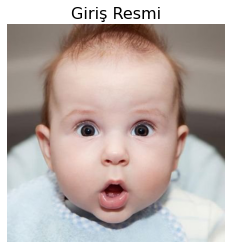

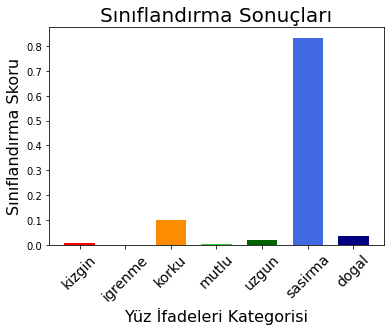

Sınıflandırma sonucu en yüksek oranla: sasirma


In [60]:
#sınıflarımız 7 adet duygu durumumuz
class_names = ['kizgin', 'igrenme', 'korku', 'mutlu', 'uzgun', 'sasirma', 'dogal']

ind = 0.1+0.6*np.arange(len(class_names))
width = 0.4  #bar genişliği

color_list = ['red','orangered','darkorange','limegreen','darkgreen','royalblue','navy']

# test resmimizi çizdirelim

plt.imshow(test_image_original)
plt.title('Giriş Resmi', fontsize=16)
plt.axis('off')
plt.show()

#sonuçlarımızı renklendirelim

for i in range(len(class_names)):
  plt.bar(ind[i], results[0][i], width, color=color_list[i])

plt.title("Sınıflandırma Sonuçları", fontsize=20)
plt.xlabel("Yüz İfadeleri Kategorisi",fontsize=16)
plt.ylabel("Sınıflandırma Skoru",fontsize=16)
plt.xticks(ind, class_names, rotation=45, fontsize=14)
plt.show()


print("Sınıflandırma sonucu en yüksek oranla:", class_names[np.argmax(results)])

